In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.image import DirectoryIterator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import cv2
from tensorflow.keras.utils import Sequence


# === STEP 1: Load dataset info (file names, labels) ===
def get_image_info(base_dir):
    all_data = []
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(base_dir, split)
        for class_name in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, class_name)
            if os.path.isdir(class_dir):
                for img_file in os.listdir(class_dir):
                    if img_file.lower().endswith(('jpg', 'jpeg', 'png')):
                        all_data.append([split, class_name, os.path.join(class_dir, img_file)])
    return pd.DataFrame(all_data, columns=["split", "label", "filepath"])

df = get_image_info("/mnt/c/Users/muham/Documents/Documents/Tugas Kuliah/Tugas Kuliah Semester 6/Deep-Learning/Week 8 (UTS)/FishImgDataset")
print(df.head())

2025-04-29 20:15:20.787675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745932520.814329   43504 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745932520.822568   43504 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-29 20:15:20.859283: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


   split   label                                           filepath
0  train  Bangus  /mnt/c/Users/muham/Documents/Documents/Tugas K...
1  train  Bangus  /mnt/c/Users/muham/Documents/Documents/Tugas K...
2  train  Bangus  /mnt/c/Users/muham/Documents/Documents/Tugas K...
3  train  Bangus  /mnt/c/Users/muham/Documents/Documents/Tugas K...
4  train  Bangus  /mnt/c/Users/muham/Documents/Documents/Tugas K...


In [2]:
# Bersihkan label
df['label'] = df['label'].str.strip().str.lower()

# Label encoding
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# One-hot encoding
one_hot = pd.get_dummies(df['label'])
df = pd.concat([df, one_hot], axis=1)

In [3]:
target_size = (150, 150)
batch_size = 64

def resize_with_padding(img, target_size=(150, 150)):
    old_size = img.shape[:2]  # (height, width)
    ratio = min(target_size[0] / old_size[0], target_size[1] / old_size[1])
    new_size = tuple([int(x * ratio) for x in old_size[::-1]])

    resized = cv2.resize(img, new_size)

    delta_w = target_size[1] - new_size[0]
    delta_h = target_size[0] - new_size[1]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0]
    new_img = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_img

class CustomDirectoryIterator(DirectoryIterator):
    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=self.dtype)
        for i, j in enumerate(index_array):
            fname = self.filepaths[j]
            img = cv2.imread(fname)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = resize_with_padding(img, self.target_size)
            img = img.astype(self.dtype) / 255.0
            batch_x[i] = img

        # Apply labels
        if self.class_mode == 'categorical':
            batch_y = np.zeros((len(batch_x), len(self.class_indices)), dtype=self.dtype)
            for i, label in enumerate(self.classes[index_array]):
                batch_y[i, label] = 1.
        else:
            batch_y = self.classes[index_array]

        return batch_x, batch_y

train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1
)

train_generator = CustomDirectoryIterator(
    directory="/mnt/c/Users/muham/Documents/Documents/Tugas Kuliah/Tugas Kuliah Semester 6/Deep-Learning/Week 8 (UTS)/FishImgDataset/train",
    image_data_generator=train_datagen,
    target_size=target_size,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

val_generator = CustomDirectoryIterator(
    directory="/mnt/c/Users/muham/Documents/Documents/Tugas Kuliah/Tugas Kuliah Semester 6/Deep-Learning/Week 8 (UTS)/FishImgDataset/val",
    image_data_generator=ImageDataGenerator(),
    target_size=target_size,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

test_generator = CustomDirectoryIterator(
    directory="/mnt/c/Users/muham/Documents/Documents/Tugas Kuliah/Tugas Kuliah Semester 6/Deep-Learning/Week 8 (UTS)/FishImgDataset/test",
    image_data_generator=ImageDataGenerator(),
    target_size=target_size,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False
)

Found 8801 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1760 images belonging to 31 classes.


In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3) ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/home/ardi/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745932530.918690   43504 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4057 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
W0000 00:00:1745932534.982765   43681 gpu_backend_lib.cc:579] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /home/ardi/miniconda3/lib/pyt

In [5]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    batch_size=128,
    verbose=1
)

/home/ardi/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1745932547.783400   43661 service.cc:148] XLA service 0x7fa7880197c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745932547.783495   43661 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-04-29 20:15:47.929777: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745932548.738405   43661 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-29 20:15:49.939575: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[64,64,148,148]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,150,150]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"act

 50/138 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - accuracy: 0.1328 - loss: 3.3961

2025-04-29 20:18:11.177654: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[33,64,148,148]{3,2,1,0}, u8[0]{0}) custom-call(f32[33,3,150,150]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-29 20:18:11.346963: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[33,64,72,72]{3,2,1,0}, u8[0]{0}) custom-call(f32[33,64,74,74]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1880 - loss: 3.1132

2025-04-29 20:21:18.426800: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[64,64,148,148]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,150,150]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-29 20:21:18.618258: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[64,64,72,72]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,74,74]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

138/138 ━━━━━━━━━━━━━━━━━━━━ 417s 3s/step - accuracy: 0.1884 - loss: 3.1111 - val_accuracy: 0.0647 - val_loss: 3.8887
Epoch 2/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.3696 - loss: 2.2701 - val_accuracy: 0.0542 - val_loss: 4.3900
Epoch 3/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.4581 - loss: 1.8828 - val_accuracy: 0.2628 - val_loss: 2.6320
Epoch 4/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.5344 - loss: 1.5848 - val_accuracy: 0.4965 - val_loss: 1.7453
Epoch 5/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.6093 - loss: 1.3332 - val_accuracy: 0.5616 - val_loss: 1.4683
Epoch 6/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.6837 - loss: 1.0811 - val_accuracy: 0.6499 - val_loss: 1.1767
Epoch 7/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.7351 - loss: 0.8905 - val_accuracy: 0.8139 - val_loss: 0.6595
Epoch 8/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.7875 - loss: 0.7002 - val_accuracy: 0.837

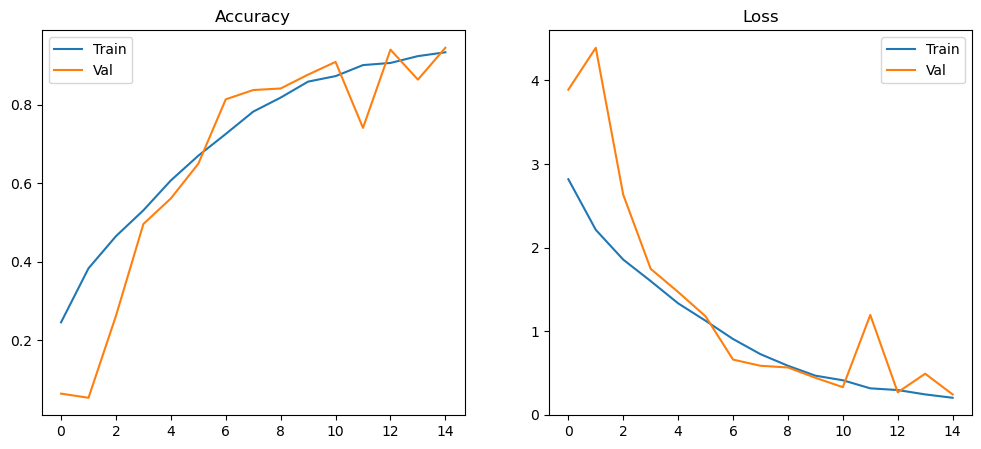

In [6]:
def plot_train_val(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_train_val(history)

2025-04-29 21:34:10.143028: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,32,34,34]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,36,36]{3,2,1,0}, f32[32,64,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-29 21:34:10.332850: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,32,15,15]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,17,17]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"

1760/1760 ━━━━━━━━━━━━━━━━━━━━ 80s 43ms/step
Accuracy: 0.9176
Precision: 0.9197
Recall: 0.9176
F1-Score: 0.9171


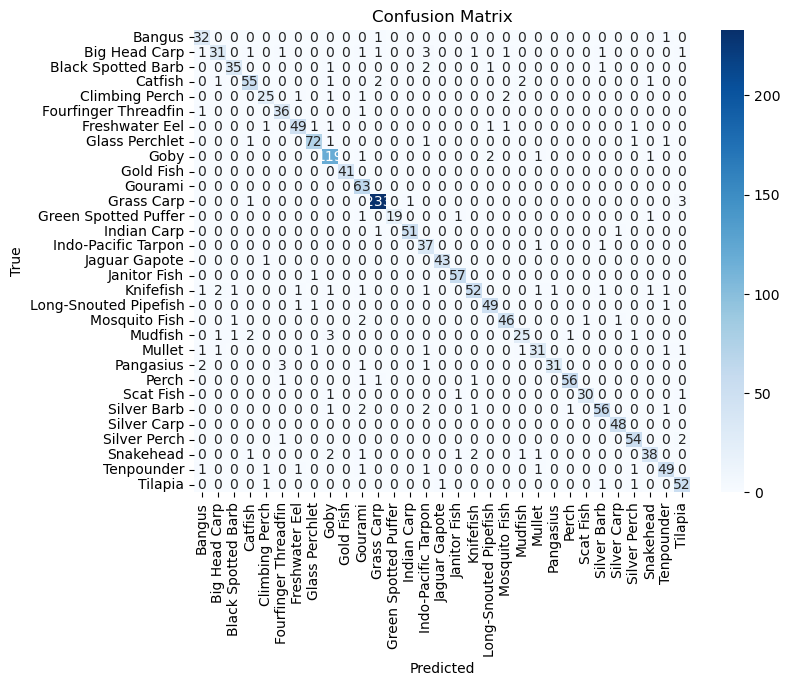

                       precision    recall  f1-score   support

               Bangus       0.82      0.94      0.88        34
        Big Head Carp       0.86      0.72      0.78        43
   Black Spotted Barb       0.92      0.88      0.90        40
              Catfish       0.90      0.89      0.89        62
       Climbing Perch       0.86      0.83      0.85        30
 Fourfinger Threadfin       0.86      0.95      0.90        38
       Freshwater Eel       0.92      0.89      0.91        55
       Glass Perchlet       0.95      0.94      0.94        77
                 Goby       0.90      0.96      0.93       124
            Gold Fish       1.00      1.00      1.00        41
              Gourami       0.82      1.00      0.90        63
           Grass Carp       0.97      0.98      0.98       238
 Green Spotted Puffer       1.00      0.86      0.93        22
          Indian Carp       0.98      0.96      0.97        53
  Indo-Pacific Tarpon       0.76      0.95      0.84  

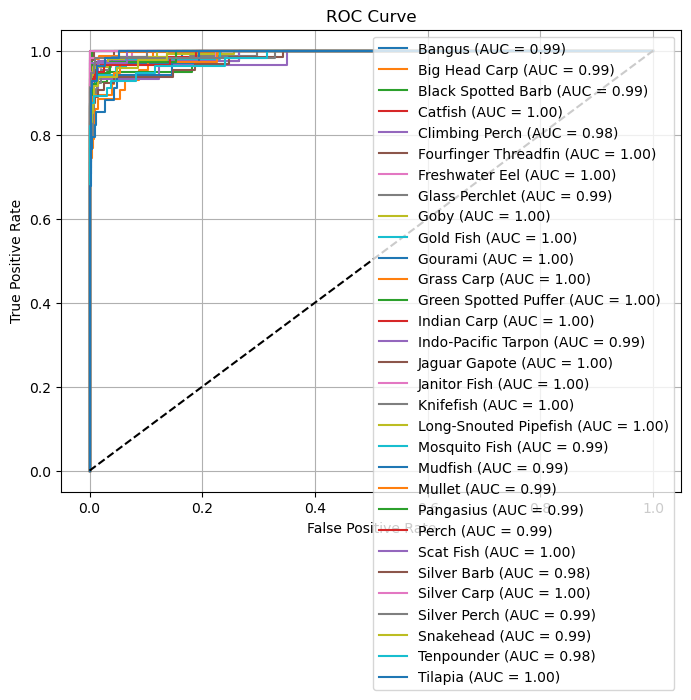

In [7]:
# Predict
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print evaluation metrics
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(), cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# AUC-ROC (One-vs-Rest)
y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes=len(test_generator.class_indices))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(test_generator.class_indices)):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC
plt.figure(figsize=(8,6))
for i, label in enumerate(test_generator.class_indices.keys()):
    plt.plot(fpr[i], tpr[i], label=f"{label} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()